In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
# zrobić z digits a nie MNIST

In [2]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from counterfactuals.datasets import MNISTDataset
from counterfactuals.losses import MulticlassDiscLoss
from counterfactuals.cf_methods.group_ppcef.rppcef import RPPCEF
from counterfactuals.generative_models import MaskedAutoregressiveFlow
from counterfactuals.discriminative_models import (
    MultilayerPerceptron,
)
from counterfactuals.metrics import CFMetrics

/Users/oleksiifurman/Developer/counterfactuals/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = MNISTDataset("../data/mnist_train.csv")

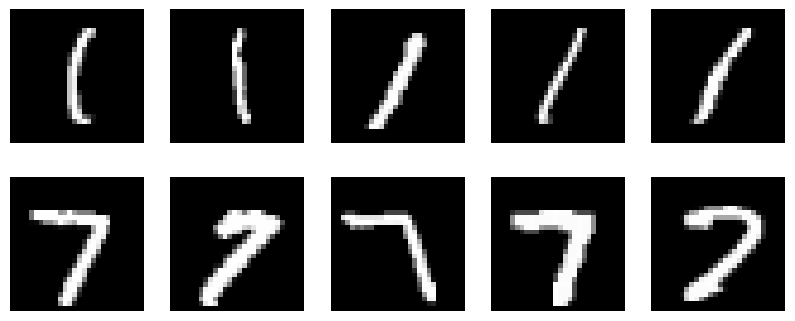

In [4]:
class_0_indices = np.where(dataset.y_train == 0)[0]
class_1_indices = np.where(dataset.y_train == 1)[0]

random_indices_class_0 = np.random.choice(class_0_indices, 5, replace=False)
random_indices_class_1 = np.random.choice(class_1_indices, 5, replace=False)

plt.figure(figsize=(10, 4))

# Plot class 0 images from train dataset
for i, idx in enumerate(random_indices_class_0):
    plt.subplot(2, 5, i + 1)
    samples = dataset.X_train[idx].reshape(28, 28)
    samples = MNISTDataset.inverse_transform(samples)
    plt.imshow(samples, cmap="gray")
    plt.axis("off")

# Plot class 1 images from train dataset
for i, idx in enumerate(random_indices_class_1):
    plt.subplot(2, 5, i + 6)
    samples = dataset.X_train[idx].reshape(28, 28)
    samples = MNISTDataset.inverse_transform(samples)
    plt.imshow(samples, cmap="gray")
    plt.axis("off")

plt.show()

In [5]:
disc_model = MultilayerPerceptron(dataset.X_test.shape[1], [512, 512], 2, device="mps")
disc_model.to("mps")
disc_model.fit(
    dataset.train_dataloader(batch_size=128, shuffle=True),
    dataset.test_dataloader(batch_size=128, shuffle=False),
    epochs=5000,
    patience=100,
    lr=1e-3,
    checkpoint_path="mnist_disc_model.pt",
)
# disc_model.load("disc_model.pt")

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/oleksiifurman/Developer/counterfactuals/counterfactuals/discriminative_models/multilayer_perceptron.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to t

In [6]:
disc_model.to("cpu")

MultilayerPerceptron(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=2, bias=True)
  )
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (final_activation): Softmax(dim=1)
  (criterion): CrossEntropyLoss()
)

In [30]:
# disc_model = LogisticRegression(dataset.X_test.shape[1], 1)
# disc_model.fit(
#     dataset.train_dataloader(batch_size=256, shuffle=True),
#     dataset.test_dataloader(batch_size=256, shuffle=False),
#     epochs=5000,
#     patience=100,
#     checkpoint_path="disc_model.pt",
# )
# # disc_model.load("disc_model.pt")

In [7]:
y_pred = disc_model.predict(dataset.X_test).detach().numpy().flatten()
print("Test accuracy:", (y_pred == dataset.y_test).mean())

Test accuracy: 0.9915449654112222


In [8]:
dataset.y_train = disc_model.predict(dataset.X_train).detach().numpy()
dataset.y_test = disc_model.predict(dataset.X_test).detach().numpy()

In [9]:
gen_model = MaskedAutoregressiveFlow(
    features=dataset.X_train.shape[1],
    hidden_features=512,
    num_blocks_per_layer=2,
    num_layers=5,
    context_features=1,
    batch_norm_within_layers=True,
    batch_norm_between_layers=True,
    use_random_permutations=True,
    device="cpu",
)
train_dataloader = dataset.train_dataloader(
    batch_size=2048, shuffle=True, noise_lvl=0.000
)
# train_dataloader = dataset.test_dataloader(batch_size=256, shuffle=False)
test_dataloader = dataset.test_dataloader(batch_size=2048, shuffle=False)

gen_model.fit(
    train_dataloader,
    test_dataloader,
    learning_rate=1e-4,
    patience=10,
    num_epochs=100,
    checkpoint_path="flow.pth",
)
# # gen_model.load("flow.pth")

Epoch 99, Train: 2.1031, test: 2.3021, patience: 0: 100%|██████████| 100/100 [03:14<00:00,  1.95s/it]
/Users/oleksiifurman/Developer/counterfactuals/counterfactuals/generative_models/maf/maf.py:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an

In [10]:
input = dataset.X_train
input = torch.tensor(input, dtype=torch.float32)

labels = dataset.y_train
labels = torch.tensor(labels, dtype=torch.float32).view(-1, 1)

gen_model.train()
print(-gen_model(input, labels).mean())

with torch.no_grad():
    output = -gen_model(input, labels).mean()
    print(output)

tensor(1142.2356, grad_fn=<NegBackward0>)
tensor(1142.2356)


In [11]:
input = dataset.X_test
input = torch.tensor(input, dtype=torch.float32)

labels = dataset.y_test
labels = torch.tensor(labels, dtype=torch.float32).view(-1, 1)

gen_model.train()
print(-gen_model(input, labels).mean())

with torch.no_grad():
    output = -gen_model(input, labels).mean()
    print(output)

tensor(1253.3228, grad_fn=<NegBackward0>)
tensor(1253.3228)


Context 0.0: 100%|██████████| 5/5 [00:00<00:00, 299.40it/s]


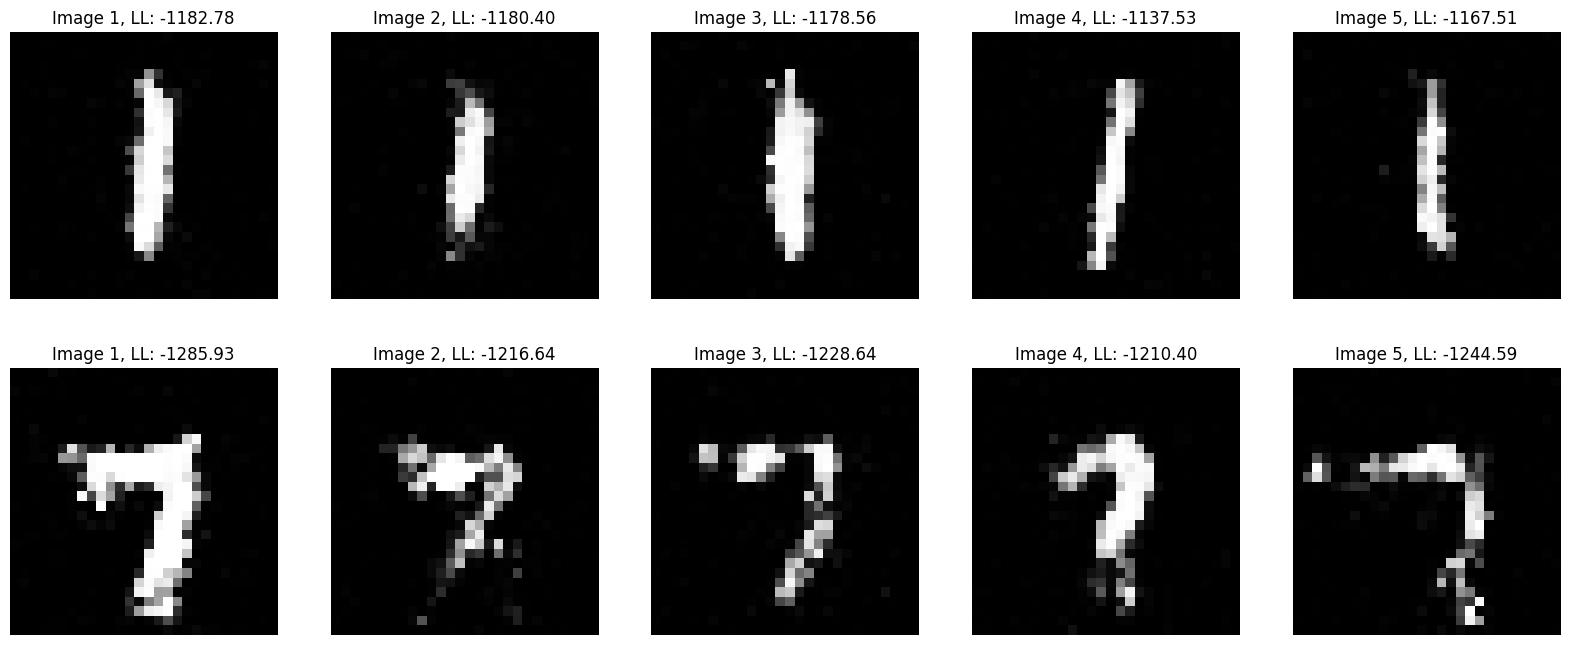

In [26]:
with torch.no_grad():
    plt.figure(figsize=(20, 8))

    # Plot images with context 1.0
    generated_images, ll = gen_model.sample_and_log_prob(5, context=torch.tensor([0.0]))
    for i in tqdm(range(5), desc="Context 1.0"):
        plt.subplot(2, 5, i + 1)
        samples = generated_images[0][i].view(28, 28).detach()
        samples = MNISTDataset.inverse_transform(samples)
        plt.imshow(samples, cmap="gray")
        plt.title(f"Image {i+1}, LL: {ll[0][i].item():.2f}")
        plt.axis("off")

    # Plot images with context 0.0
    generated_images, ll = gen_model.sample_and_log_prob(5, context=torch.tensor([1.0]))
    for i in tqdm(range(5), desc="Context 0.0"):
        plt.subplot(2, 5, i + 6)
        samples = generated_images[0][i].view(28, 28).detach()
        samples = MNISTDataset.inverse_transform(samples)
        plt.imshow(samples, cmap="gray")
        plt.title(f"Image {i+1}, LL: {ll[0][i].item():.2f}")
        plt.axis("off")

    plt.show()

In [13]:
source_class = 0
target_class = 1
X_test_origin = dataset.X_test[dataset.y_test == source_class]
y_test_origin = dataset.y_test[dataset.y_test == source_class]

In [15]:
cf_method = RPPCEF(
    X=X_test_origin,
    cf_method_type="PPCEF_2",
    K=20,
    gen_model=gen_model,
    disc_model=disc_model,
    disc_model_criterion=MulticlassDiscLoss(eps=0.1),
    actionable_features=None,
    neptune_run=None,
)

In [16]:
train_dataloader_for_log_prob = dataset.train_dataloader(batch_size=4096, shuffle=False)
log_prob_threshold = torch.quantile(
    gen_model.predict_log_prob(train_dataloader_for_log_prob),
    0.5,
)

cf_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_test_origin).float(),
        torch.tensor(y_test_origin).float(),
    ),
    batch_size=4096,
    shuffle=False,
)


delta, Xs, ys_orig, ys_target = cf_method.explain_dataloader(
    dataloader=cf_dataloader,
    epochs=1000,
    lr=0.01,
    patience=1000,
    alpha_dist=1e-3,
    alpha_plaus=10**3,
    alpha_class=10**5,
    alpha_s=10**2,
    alpha_k=10**2,
    log_prob_threshold=log_prob_threshold,
)

loss: 0.0005, dist: 0.5413, max_inner: 0.0000, loss_disc: 0.0000, delta_loss: 0.0000: 100%|██████████| 1000/1000 [02:28<00:00,  6.73it/s]              


In [17]:
M, S, D = delta.get_matrices()

In [18]:
S.sum(axis=0)

tensor([1342., 1342., 1342.,  ..., 1342., 1342., 1342.])

In [19]:
values, indexes = S.max(dim=1)

total = len(values)
i_correct = indexes[values == 1]
print(f"Correct: {len(i_correct)}/{total}")
print(len(set(i_correct.tolist())))

Correct: 1342/1342
1


In [20]:
Xs_cfs = Xs + delta().detach().numpy()

In [21]:
y_pred = disc_model.predict(Xs_cfs).detach().numpy().flatten()
print("Test accuracy:", (y_pred == ys_target).mean())

Test accuracy: 1.0


In [22]:
metrics = CFMetrics(
    X_cf=Xs_cfs,
    y_target=ys_target,
    X_train=dataset.X_train,
    y_train=dataset.y_train,
    X_test=X_test_origin,
    y_test=y_test_origin,
    disc_model=disc_model,
    gen_model=gen_model,
    continuous_features=list(range(dataset.X_train.shape[1])),
    categorical_features=dataset.categorical_features,
    prob_plausibility_threshold=log_prob_threshold,
)

In [23]:
metrics.calc_all_metrics()

{'coverage': 1.0,
 'validity': 1.0,
 'actionability': 0.0,
 'sparsity': 1.0,
 'proximity_categorical_hamming': nan,
 'proximity_categorical_jaccard': 20.83034001968059,
 'proximity_continuous_manhattan': 541.3315870768115,
 'proximity_continuous_euclidean': 20.83034001968059,
 'proximity_continuous_mad': 900.6677330801633,
 'proximity_l2_jaccard': 20.83034001968059,
 'proximity_mad_hamming': nan,
 'prob_plausibility': 1.0,
 'log_density_cf': -1118.2188,
 'log_density_test': -1318.9758,
 'lof_scores_cf': 1.0317233,
 'lof_scores_test': 1.0385438,
 'isolation_forest_scores_cf': 0.09652075977975298,
 'isolation_forest_scores_test': 0.08968512211303223}

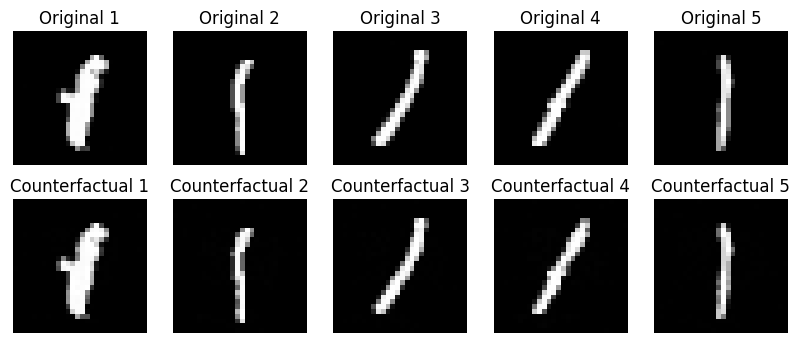

In [25]:
X_test_origin, Xs_cfs
random_indices = np.random.choice(len(X_test_origin), 5, replace=False)

plt.figure(figsize=(10, 4))

for i, idx in enumerate(random_indices):
    # Plot original image
    plt.subplot(2, 5, i + 1)
    original_image = MNISTDataset.inverse_transform(X_test_origin[idx].reshape(28, 28))
    plt.imshow(original_image, cmap="gray")
    plt.title(f"Original {i+1}")
    plt.axis("off")

    # Plot counterfactual image
    plt.subplot(2, 5, i + 6)
    cf_image = MNISTDataset.inverse_transform(Xs_cfs[idx].reshape(28, 28))
    plt.imshow(cf_image, cmap="gray")
    plt.title(f"Counterfactual {i+1}")
    plt.axis("off")

plt.show()

# TODO
1. Wziąć duo więcej próbek
2. Bez grupowych spróbować
3. Grupowe bez triku
3. Poprawić dekwantyzacje (nie powinno tak być)
4. Przeanalizować ręcznie LOF oraz IsoForest (czy działa na obrazkach)
4.5 IsoForest - zrobić głębokie drzewa

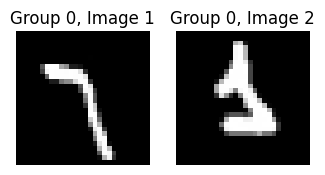

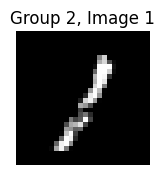

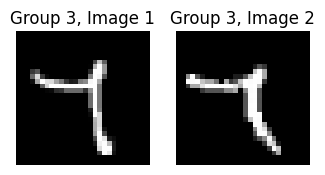

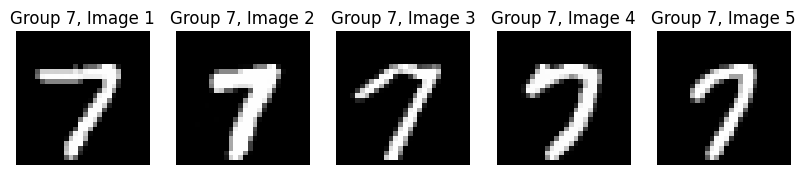

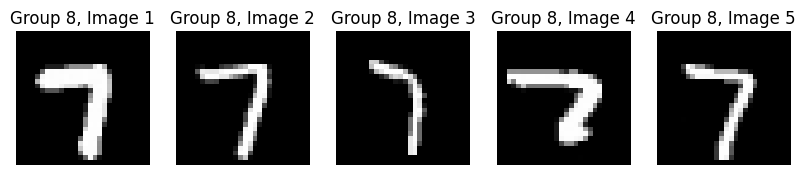

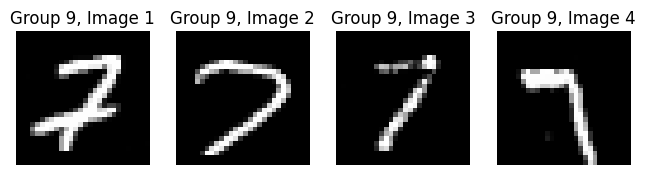

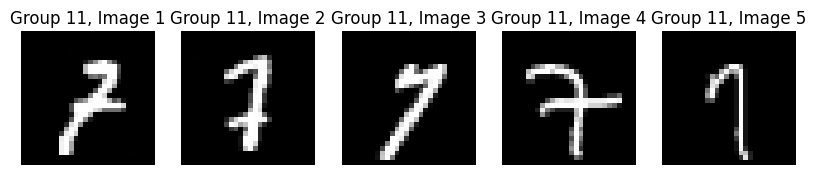

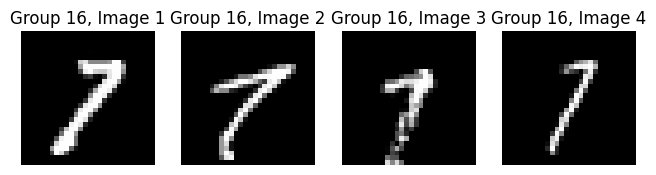

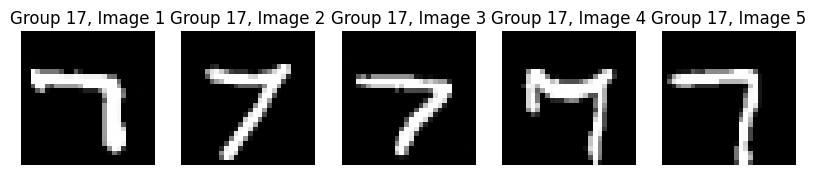

In [50]:
unique_groups = torch.unique(S.argmax(dim=1))

for group in unique_groups:
    group_indices = np.where(S.argmax(dim=1).numpy() == group.item())[0]
    num_images = min(5, len(group_indices))
    selected_indices = group_indices[:num_images]

    plt.figure(figsize=(10, 2 * num_images))
    for i, idx in enumerate(selected_indices):
        plt.subplot(1, 5, i + 1)
        plt.imshow(
            MNISTDataset.inverse_transform(X_test_origin[idx].reshape(28, 28)),
            cmap="gray",
        )
        plt.title(f"Group {group.item()}, Image {i+1}")
        plt.axis("off")
    plt.show()

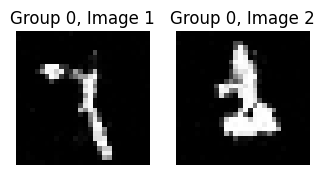

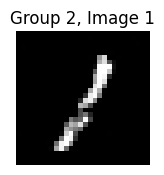

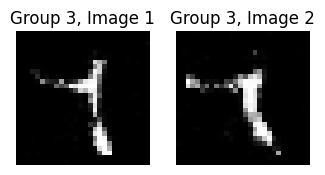

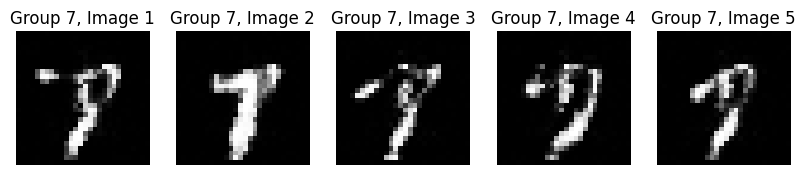

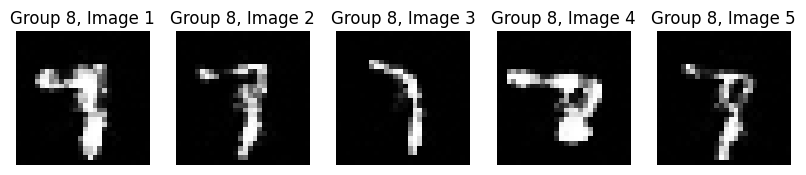

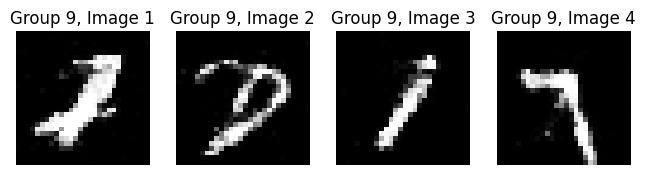

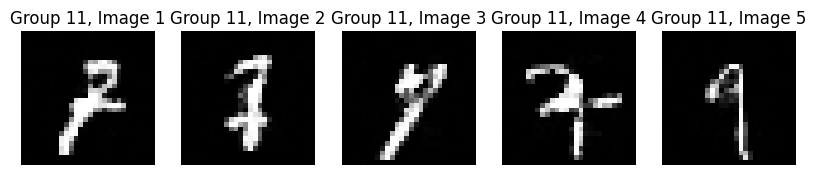

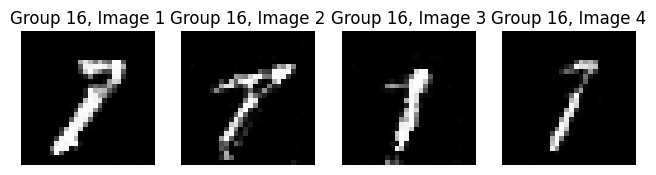

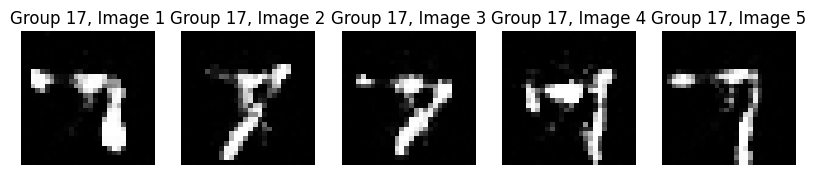

In [51]:
unique_groups = torch.unique(S.argmax(dim=1))

for group in unique_groups:
    group_indices = np.where(S.argmax(dim=1).numpy() == group.item())[0]
    num_images = min(5, len(group_indices))
    selected_indices = group_indices[:num_images]

    plt.figure(figsize=(10, 2 * num_images))
    for i, idx in enumerate(selected_indices):
        plt.subplot(1, 5, i + 1)
        plt.imshow(
            MNISTDataset.inverse_transform(Xs_cfs[idx].reshape(28, 28)), cmap="gray"
        )
        plt.title(f"Group {group.item()}, Image {i+1}")
        plt.axis("off")
    plt.show()